# Investigate correlations between raw and residual-adjusted values for methylation

In [1]:
library(CpGWAS)
library(pgenlibr)
library(bsseq)
library(data.table)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loa

In [2]:
pvar_path <- "/dcs04/lieber/statsgen/shizhong/michael/mwas/gwas/libd_chr1.pvar"
pgen_path <- snp_data_path <- "/dcs04/lieber/statsgen/shizhong/michael/mwas/gwas/libd_chr1.pgen"

In [3]:
methylation_data_path <- "/dcs04/lieber/statsgen/shizhong/michael/mwas/pheno/dlpfc/out/chr1_all.rda"
cov_path <- "/dcs04/lieber/statsgen/mnagle/mwas/full_covariates/all_dlpfc.csv"

In [4]:
load(methylation_data_path)

## Load and organize data

In [5]:
# Processing methylation data from BSseq object
methylations <- t(as.matrix(getMeth(BSobj2, type = "smooth", what = "perBase")))
colnames(methylations) <- paste0("pos_",
                                 GenomicRanges::start(
                                   GenomicRanges::ranges(
                                     SummarizedExperiment::rowRanges(BSobj2))))

# Read SNP data using pgenlibr with error handling
scaffold_name <- tools::file_path_sans_ext(basename(snp_data_path))
pgen_path <- gsub(snp_data_path, pattern = "pvar", replacement = "pgen")
pvar_path <- gsub(snp_data_path, pattern = "pgen", replacement = "pvar")
psam_path <- gsub(pvar_path, pattern = "pvar", replacement = "psam")

if (!file.exists(pgen_path) || !file.exists(pvar_path) || !file.exists(psam_path)) {
  stop("One or more SNP data files not found at the specified paths.")
}

pvar.1 <- pgenlibr::NewPvar(pvar_path)
pvar.2 <- fread(pvar_path)
pgen <- pgenlibr::NewPgen(pgen_path, pvar = pvar.1)
psam <- fread(psam_path)
psam_in_wgbs <- psam[which(psam$`#IID` %in% rownames(methylations))]

In [6]:
processCovariates <- function(cov_path){
  cov <- read.csv(cov_path, stringsAsFactors = TRUE)
  rownames(cov) <- cov$ID
  cov <- cov[, -1]
  
  # Get the indices of the factor columns
  factor_columns <- sapply(cov, is.factor)
  
  # One-hot encode the factor columns using model.matrix
  one_hot_encoded <- model.matrix(~., data = cov[, factor_columns])
  
  # Combine the one-hot encoded columns with the numeric columns
  cov <- as.matrix(cbind(one_hot_encoded, cov[, !factor_columns]))
  
  cov <- as.matrix(cov)
}

In [7]:
cov <- processCovariates(cov_path)

In [8]:
genotype_IDs <- psam_in_wgbs$`#IID`
genotype_IDs <- intersect(rownames(methylations), genotype_IDs)
genotype_IDs <- intersect(genotype_IDs, rownames(cov))
genotype_IDs <- genotype_IDs[order(genotype_IDs)]

In [9]:
if(!identical(rownames(cov), genotype_IDs)){
  cov <- cov[which(rownames(cov) %in% genotype_IDs), ]
}

In [10]:
head(cov)

,(Intercept),DxSCZ,SexM,genoPC1,genoPC2,genoPC3,methPC1,methPC2,methPC3,methPC4,methPC5,methPC6,methPC7,methPC8,methPC9,methPC10,Age
Br1003,1,0,0,0.0649632,0.07491190,-0.1297710,-1063.85637,-178.1666,-122.61634,41.019397,-15.628191,25.7129623,-93.254520,34.98171,-1.678003,133.010687,52.57
Br1004,1,0,1,0.0521374,0.00724347,-0.1400840,124.24599,145.0820,-45.81960,236.922395,-23.319253,-78.7835407,-27.489030,-18.86389,60.377535,-6.303476,21.01
Br1007,1,0,1,0.0778691,0.04240600,0.0127688,-242.20924,337.3583,-102.68852,-180.217203,-180.319796,-27.8803204,74.632757,-31.78036,5.828085,-34.318495,57.10
Br1016,1,1,1,-0.1131540,0.02141440,0.0134199,210.62733,-677.0112,234.98172,2.795834,-4.344111,-38.0009253,-56.424583,-42.91417,-90.919412,22.720535,20.22
Br1017,1,0,0,0.0791192,0.08267400,0.0412310,56.75471,237.6796,-196.48967,-245.901087,-103.081975,51.1418952,-7.924028,136.44334,-115.072485,124.219645,48.42
Br1021,1,1,1,0.0648035,0.08840540,0.0563317,-191.46996,258.9065,-94.71372,215.970417,98.203636,-0.3541402,68.903399,-151.32822,21.843878,51.292483,63.18


## Remove the one methylation sample for which we don't have SNP data (???)

Which one is it?

In [11]:
`%!in%` = Negate(`%in%`)

In [12]:
methylations[1:10, 1:10]

,pos_792731,pos_792910,pos_792972,pos_793022,pos_793225,pos_793543,pos_793635,pos_793771,pos_793919,pos_793959
Br1003,0.9087932,0.8996200,0.8967687,0.8942966,0.8817177,0.8542957,0.8448465,0.8299662,0.8130248,0.8084048
Br1004,0.9223947,0.9280760,0.9292266,0.9299634,0.9317422,0.9315120,0.9309391,0.9297935,0.9282514,0.9277993
Br1007,0.9449515,0.9490644,0.9496138,0.9498514,0.9495221,0.9456745,0.9439775,0.9411216,0.9376951,0.9367393
Br1016,0.8332464,0.8282191,0.8275888,0.8274595,0.8299038,0.8412543,0.8457055,0.8528477,0.8610409,0.8632823
Br1017,0.8935951,0.8972131,0.8974600,0.8974198,0.8957747,0.8894978,0.8871005,0.8832873,0.8789963,0.8778488
Br1021,0.9423477,0.9446741,0.9447732,0.9446568,0.9428178,0.9362295,0.9336396,0.9293900,0.9243735,0.9229809
Br1023,0.9336302,0.9366746,0.9369868,0.9370346,0.9358538,0.9306535,0.9286469,0.9254861,0.9220311,0.9211375
Br1030,0.9737736,0.9691090,0.9683158,0.9682230,0.9680183,0.9642738,0.9625017,0.9593694,0.9553385,0.9541536
Br1034,0.9320662,0.9317140,0.9305500,0.9292906,0.9216877,0.9018124,0.8943021,0.8819066,0.8669889,0.8627735
Br1039,0.8744805,0.8624045,0.8601009,0.8584889,0.8524789,0.8452023,0.8436814,0.8419795,0.8409232,0.8407878


In [13]:
length(rownames(methylations))

[1] 164

In [14]:
setdiff(rownames(methylations), genotype_IDs)

[1] "Br2267"

In [15]:
methylations <- methylations[which(rownames(methylations) %in% genotype_IDs), ]

## Regress methylation data over covariates and collect residuals

As a sanity test, let's do this with base R `lm` to make sure there's nothing wrong with our code and we get the same result.

To save time for this test, select subset of data.

In [16]:
dim(methylations)

[1]     163 2202819

In [17]:
set.seed(42)
methylations_filtered <- methylations[, sample(ncol(methylations), 1000)]

In [18]:
regress_out_cov <- function(methylations, cov, n_benchmarks = NULL) {
  #print("We just entered regress_out_cov()")

  if(is.null(methylations)){
    stop("Error: methylation data not found")
  }

  #cat("Dimensions of methylations: ", dim(methylations), "\n")

  # Creating the model formula
  colnames(cov) <- gsub("\\(Intercept\\)", "Intercept", colnames(cov))
  cov <- as.data.frame(cov)
  model_formula <- as.formula(paste("y ~ ", paste(colnames(cov), collapse=" + ")))

  n_tests <- if (is.null(n_benchmarks)) ncol(methylations) else n_benchmarks
  residuals_matrix <- matrix(NA, nrow = nrow(methylations), ncol = n_tests)

  for(i in 1:n_tests) {
    y <- methylations[, i]
    lm_model <- lm(model_formula, data = cbind(y, cov))
    residuals_matrix[, i] <- residuals(lm_model)
  }
  
  colnames(residuals_matrix) <- colnames(methylations)
  rownames(residuals_matrix) <- rownames(methylations)

  #cat("Residuals computed for ", n_tests, " tests.\n")
  return(residuals_matrix)
}

In [19]:
methylations_filtered_resid <- regress_out_cov(methylations_filtered,
                                               cov)

In [20]:
# Convert matrices to vectors
vector1 <- as.vector(methylations_filtered)
vector2 <- as.vector(methylations_filtered_resid)

# Create a data frame for plotting
combined_data <- data.frame(matrix1_values = vector1, 
                            matrix2_values = vector2)

# Use ggplot2 for scatterplot with regression line
library(ggplot2)

plot <- ggplot(combined_data, aes(x = matrix1_values, y = matrix2_values)) +
  geom_point(alpha = 0.2) +  # Adjust alpha for visibility if many points
  geom_smooth(method = "lm", color = "blue") +  # Regression line
  theme_minimal() +
theme(text = element_text(size = 20),  # Increase general text size
        axis.title = element_text(size = 22),  # Increase axis title size
        plot.title = element_text(size = 24, hjust = 0.5)) +  # Increase plot title size and center it
  labs(x = "Before", y = "After", 
       title = "Methylation matrix before and after\nregressing out covariates")

In [21]:
r_squared <- cor(combined_data$matrix1_values,combined_data$matrix2_values)^2

plot <- plot + annotate("text", x = Inf, y = Inf, hjust = 1.1, vjust = 1.1, 
                        label = paste("R² =", round(r_squared, 3)), size = 7)

`geom_smooth()` using formula = 'y ~ x'


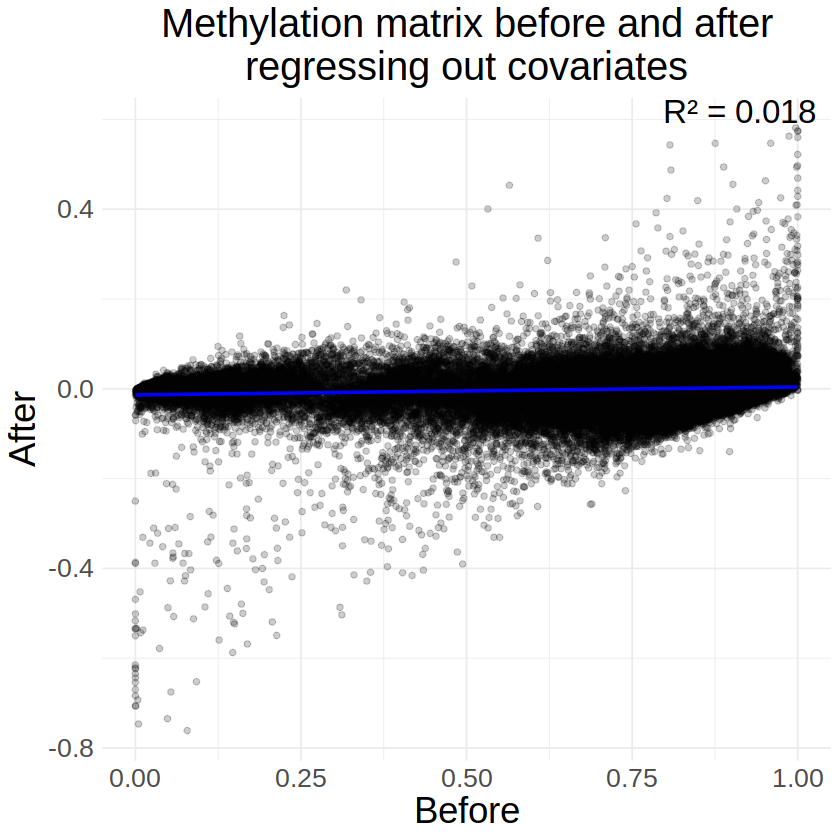

In [22]:
plot

In [23]:
regress_out_cov_parallel <- function(methylations, cov_matrix, no_cores = detectCores() - 1) {

  if(!all(rownames(methylations) == rownames(cov_matrix))) {
    stop("Error: Row names of methylation data and covariates do not match.")
  }
  
  residuals_computation <- function(chunk, cov_matrix, pseudoinv) {
    fitted_values <- cov_matrix %*% (pseudoinv %*% chunk)
    return(chunk - fitted_values)
  }
  
  if(is.null(methylations)){
    stop("Error: methylation data not found")
  }

  pseudoinv <- solve(t(cov_matrix) %*% cov_matrix) %*% t(cov_matrix)
  
  # Calculate the number of columns per chunk
  # Ensure there's no division by zero or incorrect chunk size when no_cores > ncol(methylations)
  no_cores <- min(no_cores, ncol(methylations))
  chunk_size <- max(1, ceiling(ncol(methylations) / no_cores))
  
  chunks <- list()
  for (i in 1:no_cores) {
    start_col <- (i - 1) * chunk_size + 1
    end_col <- min(i * chunk_size, ncol(methylations))
    if (start_col <= ncol(methylations)) { # Ensure start_col is within the column range
      chunks[[i]] <- methylations[, start_col:end_col, drop = FALSE]
    }
  }
  
  if(no_cores > 1 && (ncol(methylations) > no_cores)){
    results <- future_lapply(chunks, residuals_computation, cov_matrix = cov_matrix, pseudoinv = pseudoinv)
    residuals_matrix <- do.call(cbind, results)
  } else {
    residuals_matrix <- residuals_computation(methylations, cov_matrix, pseudoinv)
  }
  
  # Ensure the column names of the residuals_matrix match those of the original methylations matrix
  if(!all(colnames(methylations) == colnames(residuals_matrix))) {
    stop("Error: Residuals in different order than inputs.")
  }
  
  return(residuals_matrix)
}

In [27]:
library(parallel)
library(future.apply)

Loading required package: future



In [28]:
methylations_filtered_resid <- regress_out_cov_parallel(methylations_filtered,
                                                        cov)

In [29]:
# Convert matrices to vectors
vector1 <- as.vector(methylations_filtered)
vector2 <- as.vector(methylations_filtered_resid)

# Create a data frame for plotting
combined_data <- data.frame(matrix1_values = vector1, 
                            matrix2_values = vector2)

# Use ggplot2 for scatterplot with regression line
library(ggplot2)

plot <- ggplot(combined_data, aes(x = matrix1_values, y = matrix2_values)) +
  geom_point(alpha = 0.2) +  # Adjust alpha for visibility if many points
  geom_smooth(method = "lm", color = "blue") +  # Regression line
  theme_minimal() +
theme(text = element_text(size = 20),  # Increase general text size
        axis.title = element_text(size = 22),  # Increase axis title size
        plot.title = element_text(size = 24, hjust = 0.5)) +  # Increase plot title size and center it
  labs(x = "Before", y = "After", 
       title = "Methylation matrix before and after\nregressing out covariates")

In [30]:
r_squared <- cor(combined_data$matrix1_values,combined_data$matrix2_values)^2

plot <- plot + annotate("text", x = Inf, y = Inf, hjust = 1.1, vjust = 1.1, 
                        label = paste("R² =", round(r_squared, 3)), size = 7)

`geom_smooth()` using formula = 'y ~ x'


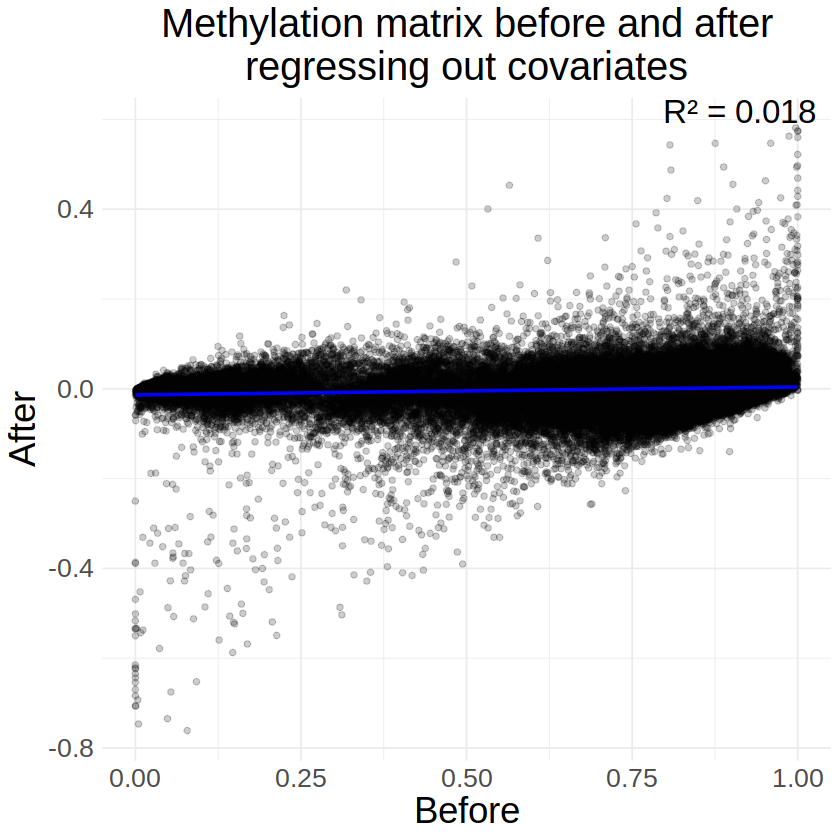

In [31]:
plot